In [1]:
from datetime import datetime
from typing import Annotated, Literal

from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import BaseMessage, add_messages
from loguru import logger
from pydantic import BaseModel

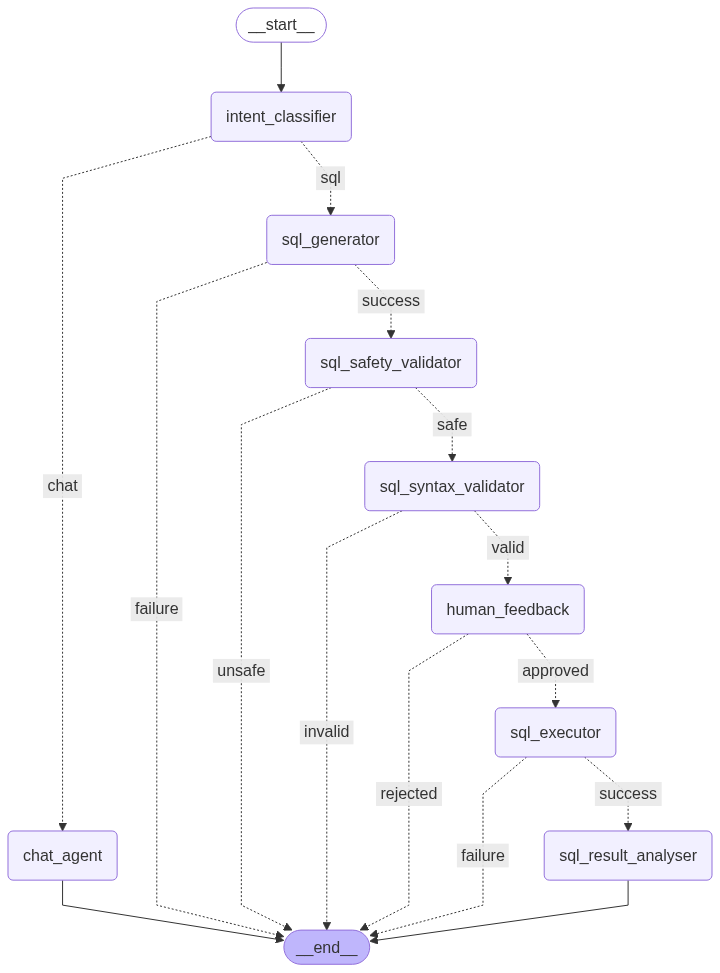

In [2]:
# ===============================
# Session-based Memory
# ===============================

# In-memory session saver
memory = InMemorySaver()

# Thread ID used to identify the session
session_id = "test_" + datetime.now().isoformat()
thread_config = {"configurable": {"thread_id": session_id}}

# ===============================
# State
# ===============================


class State(BaseModel):
    messages: Annotated[list[BaseMessage], add_messages]
    user_intent: Literal["sql", "chat"] | None = None
    sql_query: str | None = None
    sql_safety_status: Literal["safe", "unsafe"] | None = None
    sql_syntax_status: Literal["valid", "invalid"] | None = None
    user_feedback_status: Literal["approved", "rejected"] | None = None
    sql_execution_status: Literal["success", "failure"] | None = None
    sql_result: str | None = None


# ===============================
# Agent Nodes
# ===============================


def intent_classifier(state) -> dict:
    logger.info("🔄 [Node] Intent Classifier")
    if state.messages[-1].content.lower().startswith("/sql"):
        user_intent = "sql"
    else:
        user_intent = "chat"
    logger.debug(f"Detected user intent: {user_intent}")
    return {"user_intent": user_intent}


def chat_agent(state) -> dict:
    logger.info("🔄 [Node] Chat Agent")
    response = "Hello, how can I help you today?"
    logger.debug(f"✅ Chat Agent response: {response[:50]}...")
    return {"messages": AIMessage(content=response)}


def sql_generator(state) -> dict:
    logger.info("🔄 [Node] SQL Generator")
    generated_sql = "SELECT * FROM users"
    logger.debug(f"Generated SQL: {generated_sql[:50]}...")
    return {"sql_query": generated_sql}


def sql_safety_validator(state) -> dict:
    logger.info("🔄 [Node] SQL Safety Validator")
    unsafe_keywords = ["drop", "truncate"]
    if any(keyword in state.sql_query.lower() for keyword in unsafe_keywords):
        logger.debug(f"❌ SQL contains unsafe keywords: {unsafe_keywords}")
        return {"sql_safety_status": "unsafe"}
    else:
        logger.debug("✅ SQL is safe")
        return {"sql_safety_status": "safe"}


def sql_syntax_validator(state) -> dict:
    logger.info("🔄 [Node] SQL Syntax Validator")
    if state.sql_query.lower().startswith("select"):
        logger.debug("✅ SQL syntax is valid")
        return {"sql_syntax_status": "valid"}
    else:
        logger.debug("❌ SQL syntax is invalid")
        return {"sql_syntax_status": "invalid"}


def human_feedback(state) -> dict:
    logger.info("🔄 [Node] Human Feedback")
    human_feedback = "approved"
    if human_feedback == "approved":
        logger.debug(f"✅ Human feedback: {human_feedback}")
    else:
        logger.debug(f"❌ Human feedback: {human_feedback}")
    return {"user_feedback_status": human_feedback}


def sql_executor(state) -> dict:
    logger.info("🔄 [Node] SQL Executor")
    sql_execution_status = "success" if state.sql_query else "failure"
    sql_result = (
        "The result shows that..."
        if sql_execution_status == "success"
        else "The SQL query failed to execute."
    )
    if sql_execution_status == "success":
        logger.debug(f"✅ SQL execution status: {sql_execution_status}")
        logger.debug(f"✅ SQL result: {sql_result[:50]}...")
    else:
        logger.debug(f"❌ SQL execution status: {sql_execution_status}")
        logger.debug(f"❌ SQL result: {sql_result}")
    return {"sql_execution_status": sql_execution_status, "sql_result": sql_result}


def sql_result_analyser(state) -> dict:
    logger.info("🔄 [Node] SQL Result Analyser")
    logger.debug(f"✅ SQL Agent response: {state.sql_result[:50]}...")
    return {"messages": AIMessage(content=state.sql_result)}


# ===============================
# Node Rounters
# ===============================


def route_intent(state) -> Literal["sql", "chat"]:
    # logger.debug("🔄 [Router] Route Intent")
    logger.debug(f"→ Routing to {state.user_intent}")
    return state.user_intent


def check_sql_generation(state) -> Literal["success", "failure"]:
    # logger.debug("🔄 [Router] Check SQL Generation")
    if state.sql_query:
        logger.debug("→ Routing to success")
        return "success"
    else:
        logger.debug("→ Routing to failure")
        return "failure"


def check_sql_safety(state) -> Literal["safe", "unsafe"]:
    # logger.debug("🔄 [Router] Check SQL Safety")
    logger.debug(f"→ Routing to {state.sql_safety_status}")
    return "safe" if state.sql_safety_status == "safe" else "unsafe"


def check_sql_syntax(state) -> Literal["valid", "invalid"]:
    # logger.debug("🔄 [Router] Check SQL Syntax")
    logger.debug(f"→ Routing to {state.sql_syntax_status}")
    return "valid" if state.sql_syntax_status == "valid" else "invalid"


def check_human_feedback(state) -> Literal["approved", "rejected"]:
    # logger.debug("🔄 [Router] Check Human Feedback")
    logger.debug(f"→ Routing to {state.user_feedback_status}")
    return "approved" if state.user_feedback_status == "approved" else "rejected"


def check_sql_execution(state) -> Literal["success", "failure"]:
    # logger.debug("🔄 [Router] Check SQL Execution")
    logger.debug(f"→ Routing to {state.sql_execution_status}")
    return "success" if state.sql_execution_status == "success" else "failure"


# ===============================
# Graph
# ===============================

# State Workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("intent_classifier", intent_classifier)
workflow.add_node("chat_agent", chat_agent)
workflow.add_node("sql_generator", sql_generator)
workflow.add_node("sql_safety_validator", sql_safety_validator)
workflow.add_node("sql_syntax_validator", sql_syntax_validator)
workflow.add_node("human_feedback", human_feedback)
workflow.add_node("sql_executor", sql_executor)
workflow.add_node("sql_result_analyser", sql_result_analyser)

# Add Edges
workflow.add_edge(START, "intent_classifier")

workflow.add_conditional_edges(
    "intent_classifier",
    route_intent,
    {
        "sql": "sql_generator",
        "chat": "chat_agent",
    },
)

workflow.add_conditional_edges(
    "sql_generator",
    check_sql_generation,
    {
        "success": "sql_safety_validator",
        "failure": END,
    },
)

workflow.add_conditional_edges(
    "sql_safety_validator",
    check_sql_safety,
    {
        "safe": "sql_syntax_validator",
        "unsafe": END,
    },
)

workflow.add_conditional_edges(
    "sql_syntax_validator",
    check_sql_syntax,
    {
        "valid": "human_feedback",
        "invalid": END,
    },
)

workflow.add_conditional_edges(
    "human_feedback",
    check_human_feedback,
    {
        "approved": "sql_executor",
        "rejected": END,
    },
)

workflow.add_conditional_edges(
    "sql_executor",
    check_sql_execution,
    {
        "success": "sql_result_analyser",
        "failure": END,
    },
)

workflow.add_edge("sql_result_analyser", END)
workflow.add_edge("chat_agent", END)

# Compile Graph
graph = workflow.compile(checkpointer=memory)

# Display Graph
display(graph)

In [3]:
# Simulate chat agent interaction
graph.invoke({"messages": [HumanMessage("Hi!")]}, config=thread_config)

2025-07-06 21:39:04.000 | INFO     | __main__:intent_classifier:31 - 🔄 [Node] Intent Classifier
2025-07-06 21:39:04.000 | DEBUG    | __main__:intent_classifier:36 - Detected user intent: chat
2025-07-06 21:39:04.000 | DEBUG    | __main__:route_intent:102 - → Routing to chat
2025-07-06 21:39:04.001 | INFO     | __main__:chat_agent:40 - 🔄 [Node] Chat Agent
2025-07-06 21:39:04.001 | DEBUG    | __main__:chat_agent:42 - ✅ Chat Agent response: Hello, how can I help you today?...


{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='3079e07b-4b1a-4816-a96e-879901a3e320'),
  AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, id='d6e23da9-9025-4256-99b7-b40edff03c73')],
 'user_intent': 'chat'}

In [4]:
# Simulate sql agent interaction
graph.invoke({"messages": [HumanMessage("/sql ...")]}, config=thread_config)

2025-07-06 21:39:04.007 | INFO     | __main__:intent_classifier:31 - 🔄 [Node] Intent Classifier
2025-07-06 21:39:04.007 | DEBUG    | __main__:intent_classifier:36 - Detected user intent: sql
2025-07-06 21:39:04.008 | DEBUG    | __main__:route_intent:102 - → Routing to sql
2025-07-06 21:39:04.008 | INFO     | __main__:sql_generator:46 - 🔄 [Node] SQL Generator
2025-07-06 21:39:04.008 | DEBUG    | __main__:sql_generator:48 - Generated SQL: SELECT * FROM users...
2025-07-06 21:39:04.008 | DEBUG    | __main__:check_sql_generation:108 - → Routing to success
2025-07-06 21:39:04.009 | INFO     | __main__:sql_safety_validator:52 - 🔄 [Node] SQL Safety Validator
2025-07-06 21:39:04.009 | DEBUG    | __main__:sql_safety_validator:58 - ✅ SQL is safe
2025-07-06 21:39:04.009 | DEBUG    | __main__:check_sql_safety:116 - → Routing to safe
2025-07-06 21:39:04.010 | INFO     | __main__:sql_syntax_validator:62 - 🔄 [Node] SQL Syntax Validator
2025-07-06 21:39:04.010 | DEBUG    | __main__:sql_syntax_validato

{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='3079e07b-4b1a-4816-a96e-879901a3e320'),
  AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, id='d6e23da9-9025-4256-99b7-b40edff03c73'),
  HumanMessage(content='/sql ...', additional_kwargs={}, response_metadata={}, id='59ef65df-e23a-4d9f-b364-1df9d2667618'),
  AIMessage(content='The result shows that...', additional_kwargs={}, response_metadata={}, id='9c834cee-b722-43b1-9624-3745fcf2705e')],
 'user_intent': 'sql',
 'sql_query': 'SELECT * FROM users',
 'sql_safety_status': 'safe',
 'sql_syntax_status': 'valid',
 'user_feedback_status': 'approved',
 'sql_execution_status': 'success',
 'sql_result': 'The result shows that...'}

In [5]:
# Get last state from session
graph.get_state(thread_config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='3079e07b-4b1a-4816-a96e-879901a3e320'), AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, id='d6e23da9-9025-4256-99b7-b40edff03c73'), HumanMessage(content='/sql ...', additional_kwargs={}, response_metadata={}, id='59ef65df-e23a-4d9f-b364-1df9d2667618'), AIMessage(content='The result shows that...', additional_kwargs={}, response_metadata={}, id='9c834cee-b722-43b1-9624-3745fcf2705e')], 'user_intent': 'sql', 'sql_query': 'SELECT * FROM users', 'sql_safety_status': 'safe', 'sql_syntax_status': 'valid', 'user_feedback_status': 'approved', 'sql_execution_status': 'success', 'sql_result': 'The result shows that...'}, next=(), config={'configurable': {'thread_id': 'test_2025-07-06T21:39:03.849046', 'checkpoint_ns': '', 'checkpoint_id': '1f05aec4-f71e-6b4c-800b-07892526e214'}}, metadata={'source': 'loop', 'step': 11, 'parents': {}, 'th

In [6]:
# List all states from session
list(graph.get_state_history(thread_config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='3079e07b-4b1a-4816-a96e-879901a3e320'), AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, id='d6e23da9-9025-4256-99b7-b40edff03c73'), HumanMessage(content='/sql ...', additional_kwargs={}, response_metadata={}, id='59ef65df-e23a-4d9f-b364-1df9d2667618'), AIMessage(content='The result shows that...', additional_kwargs={}, response_metadata={}, id='9c834cee-b722-43b1-9624-3745fcf2705e')], 'user_intent': 'sql', 'sql_query': 'SELECT * FROM users', 'sql_safety_status': 'safe', 'sql_syntax_status': 'valid', 'user_feedback_status': 'approved', 'sql_execution_status': 'success', 'sql_result': 'The result shows that...'}, next=(), config={'configurable': {'thread_id': 'test_2025-07-06T21:39:03.849046', 'checkpoint_ns': '', 'checkpoint_id': '1f05aec4-f71e-6b4c-800b-07892526e214'}}, metadata={'source': 'loop', 'step': 11, 'parents': {}, 't